# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

### Import and explore the data. Clean the data for outliers and missing values. 

In [4]:
# Your code here
import pandas as pd
import numpy as np

boston = pd.read_csv('../data/boston_data.csv')

### Next, we want to explore the data. Pick several varibables you think will be ost correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

In [8]:
boston.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.00000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.730912,10.509901,11.189901,0.069307,0.556710,6.30145,68.601733,3.799666,9.836634,411.688119,18.444554,355.068243,12.598936,22.312376
std,8.943922,22.053733,6.814909,0.254290,0.117321,0.67583,28.066143,2.109916,8.834741,171.073553,2.150295,94.489572,6.925173,8.837019
min,0.006320,0.000000,0.460000,0.000000,0.392000,3.56100,2.900000,1.169100,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082382,0.000000,5.190000,0.000000,0.453000,5.90275,45.800000,2.087875,4.000000,281.000000,17.375000,374.710000,7.135000,17.100000
50%,0.253715,0.000000,9.795000,0.000000,0.538000,6.23050,76.600000,3.207450,5.000000,330.000000,19.000000,391.065000,11.265000,21.400000
75%,4.053158,12.500000,18.100000,0.000000,0.631000,6.62925,94.150000,5.222125,24.000000,666.000000,20.200000,396.007500,16.910000,25.000000
max,88.976200,95.000000,27.740000,1.000000,0.871000,8.78000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,34.370000,50.000000


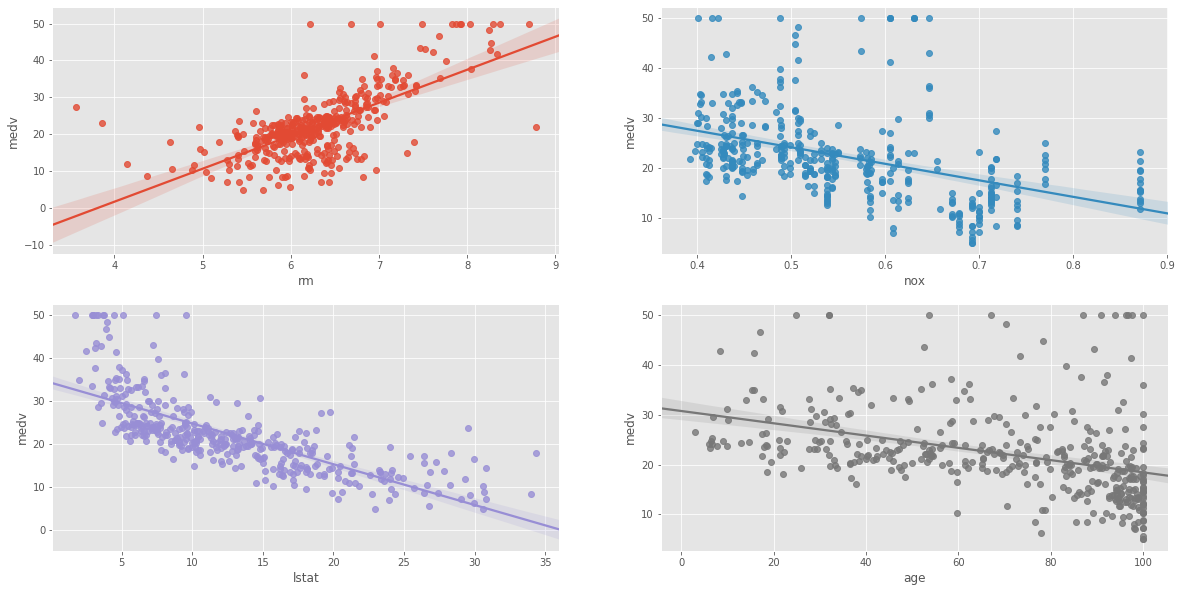

In [32]:
# Your plots here
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig, axs = plt.subplots(2,2, figsize = (20,10))
sns.regplot(x = 'rm', y = 'medv', data = boston, ax = axs[0,0])
sns.regplot(x = 'nox', y = 'medv', data = boston, ax = axs[0,1])
sns.regplot(x = 'lstat', y = 'medv', data = boston, ax = axs[1,0])
sns.regplot(x = 'age', y = 'medv', data = boston, ax = axs[1,1])

### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

### Your response here
- The more rooms, the more expensive
- The higher the nitric oxide concentration, the cheaper
- The higher the proportion of lower status population, the cheaper
- The older, the cheaper, but a good amount of variability.

### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

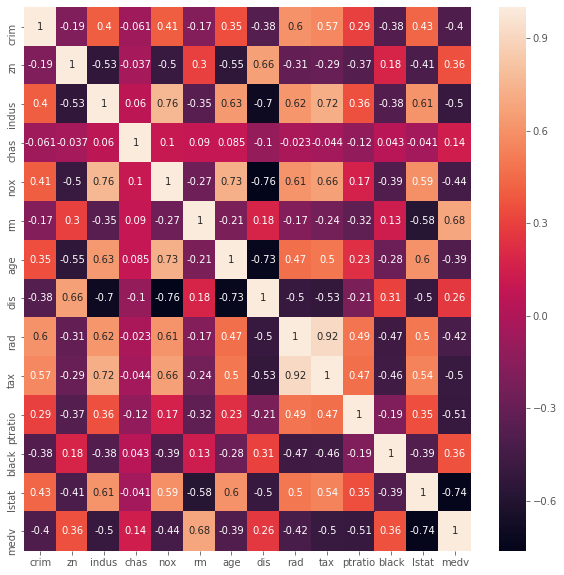

In [36]:
f = plt.subplots(figsize = (10,10))
sns.heatmap(boston.corr(), annot = True)

### Your response here
- ptratio (pupil-teacher ratio) has a 51% correlation
- tax (full value property tax rate) has a 50% correlation
- indus (proportion of non-retail business acres per town) also with 50% correlation

### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [38]:
# Your code here
boston['medv'].describe()

count    404.000000
mean      22.312376
std        8.837019
min        5.000000
25%       17.100000
50%       21.400000
75%       25.000000
max       50.000000
Name: medv, dtype: float64

----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [88]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    # Your code here:
    return r2_score(y_true, y_predict)

### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [104]:
# Your code here
from sklearn.model_selection import train_test_split

X = boston[['lstat', 'rm']]
y = boston['medv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 29)


----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [105]:
# Five separate RFR here with the given max depths
from sklearn.ensemble import RandomForestRegressor

n = [2, 4, 6, 8, 10]

def models_predicts(X_set):
    y_preds_all = []
    for x in n:
        model = RandomForestRegressor(max_depth = x).fit(X_train, y_train)
        y_pred = model.predict(X_set)
        y_preds_all.append(y_pred)
    return y_preds_all

Now, plot the score for each tree on the training set and on the testing set.

In [106]:
scores_test = [performance_metric(y_test, x) for x in models_predicts(X_test)]
scores_train = [performance_metric(y_train, x) for x in models_predicts(X_train)]

C:\Users\dandoye\Anaconda3\envs\ironhack\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dandoye\Anaconda3\envs\ironhack\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dandoye\Anaconda3\envs\ironhack\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dandoye\Anaconda3\envs\ironhack\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dan

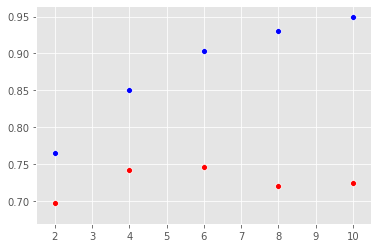

In [107]:
# Produce a plot with the score for the testing and training for the different max depths
sns.scatterplot(x = n, y = scores_test, color = 'red')
sns.scatterplot(x = n, y = scores_train, color = 'blue')

What do these results tell you about the effect of the depth of the trees on the performance of the model?

In [108]:
np.array(scores_test) - np.array(scores_train)

array([-0.06711005, -0.10874498, -0.15691246, -0.2089921 , -0.22542554])

### Your response here
- The max depth of 2 produces the least difference between the accuracy score of the test and train, so that may be the best.

### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10?

### Your response here
- Max depth of 10 would result in too much variance and little bias - we can see this with the larger difference in precision scores between the test and train at depth of 10
- Max depth of 1 would result in higher bias and little variance

### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

### Your response here
- Looking at the chart above, the best guess is using max depth of 4
- This has the balance between high accuracy for test and limited variance between test and train accuracy.
- From max depth of 6 we see the gap increase, indicating it may be starting to overfit.

### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

### Your response here
- Data from 1978 may be off in terms of actual prices, but we can adjust it for inflation to understand present day prices better.
- Ideally we would have more features - especially given that only two of the features are somewhat correlated with price.
- Given the 10% gap between the test and train accuracy scores, I would not say the model is robust enough.
- I would evaluate city vs. rural housing differently esecially given the difference in multifloor apartments vs. houses.